In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import seaborn as sns
import torch.nn.functional as F

In [20]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset class for GasHisSDB with Albumentations support
class GasHisSDBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform: Albumentations transform pipeline
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['normal', 'abnormal']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        
        # Collect samples
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                print(f"Warning: Directory {class_dir} does not exist or is not accessible")
                continue
                
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                    self.samples.append((
                        os.path.join(class_dir, img_name),
                        self.class_to_idx[class_name]
                    ))
        
        # Print dataset statistics
        self.normal_count = sum(1 for _, label in self.samples if label == 0)
        self.abnormal_count = sum(1 for _, label in self.samples if label == 1)
        print(f"Dataset loaded with {len(self.samples)} images:")
        print(f"  - Normal: {self.normal_count}")
        print(f"  - Abnormal: {self.abnormal_count}")
        
        # Safely calculate ratio
        if self.normal_count > 0:
            print(f"  - Ratio (Abnormal:Normal): {self.abnormal_count/self.normal_count:.2f}:1")
        else:
            print("  - Ratio: Cannot calculate (no normal samples found)")
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image with OpenCV for Albumentations compatibility
        try:
            # Read as BGR and convert to RGB
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error loading image {img_path}")
                # Return a placeholder black image and the label
                image = np.zeros((60, 60, 3), dtype=np.uint8)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder black image and the label
            image = np.zeros((60, 60, 3), dtype=np.uint8)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        return image, label

# Student Model: A smaller CNN suitable for 60x60 images
class StudentGastricCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(StudentGastricCNN, self).__init__()
        
        # Convolutional layers - fewer filters than teacher
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # After 3 pooling layers with stride 2: 60 -> 30 -> 15 -> 7
        # Calculate flattened size
        flattened_size = 64 * 7 * 7  # 3,136
        
        # Fully connected layers - fewer neurons, fewer layers
        self.fc_layers = nn.Sequential(
            # FC Layer 1: 3,136 -> 512
            nn.Linear(flattened_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            # FC Layer 2: 512 -> 128
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            # FC Layer 3: 128 -> 32
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            # Output Layer: 32 -> num_classes
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        # Store intermediate activations
        self.intermediate_activations = {}
        
        # Convolutional layers
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        self.intermediate_activations['conv1'] = x
        
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        self.intermediate_activations['conv2'] = x
        
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        self.intermediate_activations['conv3'] = x
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc_layers(x)
        
        return x

# Create a lighter ResNet-based student model
def create_student_resnet_model(num_classes=2):
    # Start with a ResNet18 as the base because it's smaller
    model = models.resnet18(pretrained=True)
    
    # Replace the first convolutional layer to work with smaller input size if needed
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Remove the first maxpool to keep more spatial information for smaller images
    model.maxpool = nn.Identity()
    
    # Freeze early layers
    for param in list(model.parameters())[:-20]:  # Freeze more layers than the teacher
        param.requires_grad = False
    
    # Replace with smaller FC layers
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        # FC Layer 1: num_ftrs -> 512
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        
        # FC Layer 2: 512 -> 128
        nn.Linear(512, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        
        # FC Layer 3: 128 -> 32
        nn.Linear(128, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        
        # Output Layer: 32 -> num_classes
        nn.Linear(32, num_classes)
    )
    
    # Initialize model intermediate activations
    model.intermediate_activations = {}
    
    # Add hooks to capture intermediate activations
    def get_layer_activation(name):
        def hook(module, input, output):
            model.intermediate_activations[name] = output
        return hook
    
    # Register hooks for feature maps
    model.layer1.register_forward_hook(get_layer_activation('layer1'))
    model.layer2.register_forward_hook(get_layer_activation('layer2'))
    model.layer3.register_forward_hook(get_layer_activation('layer3'))
    model.layer4.register_forward_hook(get_layer_activation('layer4'))
    
    return model

# Define a teacher ResNet model without loading weights (we'll train it briefly)
def create_teacher_resnet_model(num_classes=2):
    model = models.resnet18(pretrained=True)
    
    # Get the number of features from the last layer
    num_ftrs = model.fc.in_features
    
    # Replace with standard FC layers for simplicity
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        
        nn.Linear(512, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        
        nn.Linear(128, num_classes)
    )
    
    return model

# Define augmentations for histopathology images
def get_albumentation_transforms():
    # Train transforms for 60x60 images (student)
    student_train_transform = A.Compose([
        # Spatial augmentations
        A.Resize(60, 60),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
        
        # Color augmentations for H&E stained images
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        
        # Add some noise occasionally
        A.GaussNoise(var_limit=(10, 50), p=0.3),
        
        # Normalize and convert to tensor
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # Train transforms for 120x120 images (teacher)
    teacher_train_transform = A.Compose([
        # Spatial augmentations
        A.Resize(120, 120),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
        
        # Color augmentations for H&E stained images
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        
        # Add some noise occasionally
        A.GaussNoise(var_limit=(10, 50), p=0.3),
        
        # Normalize and convert to tensor
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # Simple transform for validation/test
    student_eval_transform = A.Compose([
        A.Resize(60, 60),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    teacher_eval_transform = A.Compose([
        A.Resize(120, 120),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    return student_train_transform, student_eval_transform, teacher_train_transform, teacher_eval_transform

# Class for knowledge distillation loss
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=4.0):
        """
        Args:
            alpha: weight for the distillation loss
            temperature: temperature for the soft targets
        """
        super(DistillationLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss()
        
    def forward(self, student_outputs, teacher_outputs, targets):
        """
        Args:
            student_outputs: logits from the student model
            teacher_outputs: logits from the teacher model
            targets: true labels
        """
        # Hard target loss - standard cross-entropy with true labels
        hard_loss = self.ce_loss(student_outputs, targets)
        
        # Soft target loss - KL divergence between softened distributions
        soft_student = F.log_softmax(student_outputs / self.temperature, dim=1)
        soft_teacher = F.softmax(teacher_outputs / self.temperature, dim=1)
        soft_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (self.temperature ** 2)
        
        # Combined loss
        return (1 - self.alpha) * hard_loss + self.alpha * soft_loss

# Helper class for applying transforms to subsets
class TransformedSubset(Dataset):
    """Apply transform to a subset of a dataset"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            augmented = self.transform(image=x)
            x = augmented['image']
        return x, y
        
    def __len__(self):
        return len(self.subset)

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    
    # Handle case where a class might not be present in the predictions
    try:
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Calculate class-specific metrics if both classes are present
        class_labels = sorted(list(set(all_labels)))
        if len(class_labels) > 1:
            precision_per_class = precision_score(all_labels, all_preds, average=None)
            recall_per_class = recall_score(all_labels, all_preds, average=None)
            f1_per_class = f1_score(all_labels, all_preds, average=None)
            
            precision_normal = precision_per_class[0] if 0 in class_labels else 0
            precision_abnormal = precision_per_class[1] if 1 in class_labels else 0
            recall_normal = recall_per_class[0] if 0 in class_labels else 0
            recall_abnormal = recall_per_class[1] if 1 in class_labels else 0
            f1_normal = f1_per_class[0] if 0 in class_labels else 0
            f1_abnormal = f1_per_class[1] if 1 in class_labels else 0
        else:
            print("Warning: Only one class present in test set")
            precision_normal = 0
            precision_abnormal = 0
            recall_normal = 0
            recall_abnormal = 0
            f1_normal = 0
            f1_abnormal = 0
    except:
        print("Warning: Error calculating precision/recall/f1 - check class balance")
        precision = 0
        recall = 0
        f1 = 0
        precision_normal = 0
        precision_abnormal = 0
        recall_normal = 0
        recall_abnormal = 0
        f1_normal = 0
        f1_abnormal = 0
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Test Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f} (Normal: {precision_normal:.4f}, Abnormal: {precision_abnormal:.4f})')
    print(f'Recall: {recall:.4f} (Normal: {recall_normal:.4f}, Abnormal: {recall_abnormal:.4f})')
    print(f'F1 Score: {f1:.4f} (Normal: {f1_normal:.4f}, Abnormal: {f1_abnormal:.4f})')
    print('\nConfusion Matrix:')
    print(cm)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_normal': precision_normal,
        'precision_abnormal': precision_abnormal,
        'recall_normal': recall_normal,
        'recall_abnormal': recall_abnormal,
        'f1_normal': f1_normal,
        'f1_abnormal': f1_abnormal,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels,
        'probabilities': all_probs
    }

# Function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 3, 3)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Validation F1')
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes=['Normal', 'Abnormal']):
    plt.figure(figsize=(8, 6))
    
    # Calculate metrics from confusion matrix
    total = np.sum(cm)
    accuracy = (cm[0, 0] + cm[1, 1]) / total if total > 0 else 0
    
    # Calculate other metrics (handle division by zero)
    precision_normal = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    precision_abnormal = cm[1, 1] / (cm[0, 1] + cm[1, 1]) if (cm[0, 1] + cm[1, 1]) > 0 else 0
    
    recall_normal = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    recall_abnormal = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    
    # Plot confusion matrix with seaborn for better styling
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
               xticklabels=classes, yticklabels=classes)
    
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.3f}\n' +
              f'Normal - Precision: {precision_normal:.3f}, Recall: {recall_normal:.3f}\n' +
              f'Abnormal - Precision: {precision_abnormal:.3f}, Recall: {recall_abnormal:.3f}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Function to train teacher model briefly
def train_teacher_model(teacher_model, train_loader, val_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
    
    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Train the model
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Training phase
        teacher_model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc='Training Teacher'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = teacher_model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        teacher_model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(val_loader, desc='Validating Teacher'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = teacher_model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Record history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())
        
        print()
    
    return teacher_model, history

# Train the student model with knowledge distillation
def train_student_with_distillation(student_model, teacher_model, train_loader, val_loader, 
                                    alpha=0.5, temperature=4.0, num_epochs=20):
    # Knowledge distillation loss
    distill_loss = DistillationLoss(alpha=alpha, temperature=temperature)
    print(f"Using distillation with alpha={alpha}, temperature={temperature}")
    
    # Optimizer and scheduler
    optimizer = optim.Adam(student_model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5, verbose=True
    )
    
    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    
    # Track best model
    best_model_wts = student_model.state_dict()
    best_acc = 0.0
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        student_model.train()
        teacher_model.eval()  # Teacher model is always in eval mode
        
        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []
        
        # Iterate over data
        for inputs, labels in tqdm(train_loader, desc='Training Student'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Resize input for teacher model
            teacher_inputs = F.interpolate(inputs, size=(120, 120), mode='bilinear', align_corners=False)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                # Get teacher predictions (no grad needed)
                with torch.no_grad():
                    teacher_outputs = teacher_model(teacher_inputs)
                
                # Get student predictions
                student_outputs = student_model(inputs)
                _, preds = torch.max(student_outputs, 1)
                
                # Calculate loss
                loss = distill_loss(student_outputs, teacher_outputs, labels)
                
                # Backward + optimize
                loss.backward()
                optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Collect predictions and labels for F1 score
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Calculate F1 score
        try:
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        except:
            epoch_f1 = 0.0
            print("Warning: F1 score calculation failed - likely missing class in predictions")
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
        
        # Record history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['train_f1'].append(epoch_f1)
        
        # Validation phase
        student_model.eval()
        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []
        
        # Iterate over validation data
        for inputs, labels in tqdm(val_loader, desc='Validating Student'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            with torch.no_grad():
                outputs = student_model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = nn.CrossEntropyLoss()(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Collect predictions and labels for F1 score
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        
        # Calculate F1 score
        try:
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        except:
            epoch_f1 = 0.0
            print("Warning: F1 score calculation failed - likely missing class in predictions")
        
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
        
        # Record history
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())
        history['val_f1'].append(epoch_f1)
        
        # Learning rate scheduling
        scheduler.step(epoch_loss)
        
        # Deep copy the model if it's the best based on F1 score
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_acc = epoch_acc
            best_model_wts = student_model.state_dict().copy()
            print(f"New best model (F1: {best_f1:.4f})")
        
        print()
    
    # Load best model weights
    student_model.load_state_dict(best_model_wts)
    return student_model, history

# Main execution function for knowledge distillation
def run_knowledge_distillation_from_scratch(data_dir, batch_size=32, num_epochs=20, 
                                  model_type='resnet', alpha=0.5, temperature=4.0):
    """
    Perform knowledge distillation from a teacher model to a student model,
    training the teacher model from scratch rather than loading it from a file
    
    Args:
        data_dir: Directory containing the dataset
        batch_size: Batch size for training
        num_epochs: Number of epochs to train student
        model_type: 'custom' or 'resnet'
        alpha: Weight for distillation loss (between 0 and 1)
        temperature: Temperature for softening probability distributions
    """
    # Get transforms for student (60x60) and teacher (120x120)
    student_train_transform, student_eval_transform, teacher_train_transform, teacher_eval_transform = get_albumentation_transforms()
    
    # Create dataset
    dataset = GasHisSDBDataset(root_dir=data_dir)
    
    # Split dataset
    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    # Random split with fixed seed for reproducibility
    train_subset, val_subset, test_subset = random_split(
        dataset, [train_size, val_size, test_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create transformed datasets
    train_dataset_teacher = TransformedSubset(train_subset, teacher_train_transform)
    val_dataset_teacher = TransformedSubset(val_subset, teacher_eval_transform)
    
    train_dataset_student = TransformedSubset(train_subset, student_train_transform)
    val_dataset_student = TransformedSubset(val_subset, student_eval_transform)
    test_dataset_student = TransformedSubset(test_subset, student_eval_transform)
    
    # Create data loaders
    train_loader_teacher = DataLoader(train_dataset_teacher, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader_teacher = DataLoader(val_dataset_teacher, batch_size=batch_size, shuffle=False, num_workers=4)
    
    train_loader_student = DataLoader(train_dataset_student, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader_student = DataLoader(val_dataset_student, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader_student = DataLoader(test_dataset_student, batch_size=batch_size, shuffle=False, num_workers=4)
    
    print(f"Dataset split: {train_size} training, {val_size} validation, {test_size} test samples")
    
    # Create teacher model
    if model_type == 'custom':
        print("Not implemented for custom model yet. Using ResNet...")
        teacher_model = create_teacher_resnet_model(num_classes=2)
    else:  # 'resnet'
        teacher_model = create_teacher_resnet_model(num_classes=2)
        print("Using ResNet-18 teacher model")
    
    # Create student model
    if model_type == 'custom':
        student_model = StudentGastricCNN(num_classes=2)
        print("Using custom CNN student model")
    else:  # 'resnet'
        student_model = create_student_resnet_model(num_classes=2)
        print("Using ResNet-18 student model")
    
    # Count parameters for both models
    student_params = sum(p.numel() for p in student_model.parameters())
    teacher_params = sum(p.numel() for p in teacher_model.parameters())
    student_trainable = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
    teacher_trainable = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
    
    print(f"Student model parameters: {student_params:,} (trainable: {student_trainable:,})")
    print(f"Teacher model parameters: {teacher_params:,} (trainable: {teacher_trainable:,})")
    print(f"Size reduction: {(1 - student_params/teacher_params)*100:.1f}%")
    
    # Move models to device
    student_model = student_model.to(device)
    teacher_model = teacher_model.to(device)
    
    # Train the teacher model
    print("\nTraining teacher model for a few epochs...")
    teacher_model, teacher_history = train_teacher_model(
        teacher_model, train_loader_teacher, val_loader_teacher, num_epochs=5
    )
    
    # Train the student model with knowledge distillation
    print("\nTraining student model with knowledge distillation...")
    student_model, student_history = train_student_with_distillation(
        student_model, teacher_model, train_loader_student, val_loader_student,
        alpha=alpha, temperature=temperature, num_epochs=num_epochs
    )
    
    # Plot training history
    plot_training_history(student_history)
    
    # Evaluate the student model
    print("\nEvaluating student model on test set:")
    student_metrics = evaluate_model(student_model, test_loader_student)
    
    # Plot confusion matrix
    plot_confusion_matrix(student_metrics['confusion_matrix'])
    
    # Evaluate the teacher model
    print("\nEvaluating teacher model on test set (resized to 120x120):")
    test_dataset_teacher = TransformedSubset(test_subset, teacher_eval_transform)
    test_loader_teacher = DataLoader(test_dataset_teacher, batch_size=batch_size, shuffle=False, num_workers=4)
    teacher_metrics = evaluate_model(teacher_model, test_loader_teacher)
    
    # Save the student model
    os.makedirs('models', exist_ok=True)
    torch.save({
        'model_state_dict': student_model.state_dict(),
        'metrics': {k: v for k, v in student_metrics.items() if not isinstance(v, np.ndarray)},
        'training_history': student_history,
        'distillation_params': {'alpha': alpha, 'temperature': temperature}
    }, f'models/student_distilled_{model_type}_60x60.pth')
    
    print(f"Student model saved as models/student_distilled_{model_type}_60x60.pth")
    
    # Compare models and parameter counts
    print("\nModel Comparison:")
    print(f"Teacher model ({model_type}): {teacher_params:,} parameters (trainable: {teacher_trainable:,})")
    print(f"Student model ({model_type}): {student_params:,} parameters (trainable: {student_trainable:,})")
    print(f"Parameter reduction: {teacher_params - student_params:,} ({(1 - student_params/teacher_params)*100:.1f}%)")
    
    print("\nPerformance Comparison:")
    print(f"Teacher model - Test Accuracy: {teacher_metrics['accuracy']:.4f}, F1: {teacher_metrics['f1']:.4f}")
    print(f"Student model - Test Accuracy: {student_metrics['accuracy']:.4f}, F1: {student_metrics['f1']:.4f}")
    
    # Compare inference speed
    print("\nInference Speed Comparison:")
    # Prepare sample batches
    sample_batch_student = next(iter(test_loader_student))[0][:5].to(device)
    sample_batch_teacher = next(iter(test_loader_teacher))[0][:5].to(device)
    
    # Measure teacher model inference time
    teacher_model.eval()
    teacher_times = []
    with torch.no_grad():
        for _ in range(10):  # Run multiple times for better estimate
            start_time = time.time()
            _ = teacher_model(sample_batch_teacher)
            teacher_times.append(time.time() - start_time)
    
    # Measure student model inference time
    student_model.eval()
    student_times = []
    with torch.no_grad():
        for _ in range(10):  # Run multiple times for better estimate
            start_time = time.time()
            _ = student_model(sample_batch_student)
            student_times.append(time.time() - start_time)
    
    avg_teacher_time = sum(teacher_times) / len(teacher_times)
    avg_student_time = sum(student_times) / len(student_times)
    speedup = avg_teacher_time / avg_student_time
    
    print(f"Teacher model average inference time: {avg_teacher_time*1000:.2f} ms")
    print(f"Student model average inference time: {avg_student_time*1000:.2f} ms")
    print(f"Speedup: {speedup:.2f}x")
    
    return student_model, teacher_model, student_history, {
        'teacher_metrics': teacher_metrics,
        'student_metrics': student_metrics,
        'teacher_params': teacher_params,
        'student_params': student_params,
        'teacher_trainable': teacher_trainable,
        'student_trainable': student_trainable,
        'reduction_percentage': (1 - student_params/teacher_params)*100,
        'teacher_inference_time': avg_teacher_time,
        'student_inference_time': avg_student_time,
        'speedup': speedup
    }

# Example usage:
# student_model, teacher_model, history, comparison = run_knowledge_distillation_from_scratch(
#     data_dir='/path/to/dataset',
#     model_type='resnet',  # or 'custom'
#     num_epochs=20,
#     alpha=0.5,  # Distillation weight
#     temperature=4.0  # Temperature for softening
# )

Using device: cuda


/tmp/ipykernel_2157895/111383902.py:252: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.3),
/tmp/ipykernel_2157895/111383902.py:271: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.3),


Dataset loaded with 146937 images:
  - Normal: 21961
  - Abnormal: 124976
  - Ratio (Abnormal:Normal): 5.69:1
Dataset split: 102855 training, 22040 validation, 22042 test samples
Using ResNet-18 teacher model
Using ResNet-18 student model
Student model parameters: 11,502,690 (trainable: 9,317,922)
Teacher model parameters: 11,506,370 (trainable: 11,506,370)
Size reduction: 0.0%

Training teacher model for a few epochs...
Epoch 1/5


Training Teacher:   0%|          | 0/3215 [00:00<?, ?it/s]

Train Loss: 0.3757 Acc: 0.8520


Validating Teacher:   0%|          | 0/689 [00:00<?, ?it/s]

Val Loss: 0.3439 Acc: 0.8685

Epoch 2/5


Training Teacher:   0%|          | 0/3215 [00:00<?, ?it/s]

Train Loss: 0.3430 Acc: 0.8614


Validating Teacher:   0%|          | 0/689 [00:00<?, ?it/s]

Val Loss: 0.2900 Acc: 0.8807

Epoch 3/5


Training Teacher:   0%|          | 0/3215 [00:00<?, ?it/s]

Train Loss: 0.3170 Acc: 0.8731


Validating Teacher:   0%|          | 0/689 [00:00<?, ?it/s]

Val Loss: 0.2555 Acc: 0.9015

Epoch 4/5


Training Teacher:   0%|          | 0/3215 [00:00<?, ?it/s]

Train Loss: 0.2938 Acc: 0.8839


Validating Teacher:   0%|          | 0/689 [00:00<?, ?it/s]

Val Loss: 0.3263 Acc: 0.8642

Epoch 5/5


Training Teacher:   0%|          | 0/3215 [00:00<?, ?it/s]

Train Loss: 0.2721 Acc: 0.8947


Validating Teacher:   0%|          | 0/689 [00:00<?, ?it/s]

Val Loss: 0.2000 Acc: 0.9248


Training student model with knowledge distillation...
Using distillation with alpha=0.5, temperature=4.0
Epoch 1/20
----------


/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

Train Loss: 0.2431 Acc: 0.8564 F1: 0.8028


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2405 Acc: 0.9029 F1: 0.8885
New best model (F1: 0.8885)

Epoch 2/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.2158 Acc: 0.8656 F1: 0.8240


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2330 Acc: 0.9087 F1: 0.8949
New best model (F1: 0.8949)

Epoch 3/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.2070 Acc: 0.8682 F1: 0.8284


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2305 Acc: 0.9036 F1: 0.8857

Epoch 4/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.2023 Acc: 0.8709 F1: 0.8326


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2428 Acc: 0.8937 F1: 0.8681

Epoch 5/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1979 Acc: 0.8732 F1: 0.8366


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2251 Acc: 0.9053 F1: 0.8877

Epoch 6/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1955 Acc: 0.8736 F1: 0.8375


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2055 Acc: 0.9188 F1: 0.9094
New best model (F1: 0.9094)

Epoch 7/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1941 Acc: 0.8748 F1: 0.8390


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2102 Acc: 0.9137 F1: 0.8998

Epoch 8/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1924 Acc: 0.8756 F1: 0.8405


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2220 Acc: 0.9064 F1: 0.8891

Epoch 9/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1909 Acc: 0.8771 F1: 0.8435


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2308 Acc: 0.8998 F1: 0.8780

Epoch 10/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1910 Acc: 0.8779 F1: 0.8445


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2143 Acc: 0.9158 F1: 0.9036

Epoch 11/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1897 Acc: 0.8772 F1: 0.8436


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2275 Acc: 0.9016 F1: 0.8808

Epoch 12/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1894 Acc: 0.8776 F1: 0.8441


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2238 Acc: 0.9004 F1: 0.8786

Epoch 13/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1822 Acc: 0.8819 F1: 0.8510


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2052 Acc: 0.9148 F1: 0.9011

Epoch 14/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1806 Acc: 0.8819 F1: 0.8514


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2042 Acc: 0.9137 F1: 0.8993

Epoch 15/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1796 Acc: 0.8827 F1: 0.8526


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2180 Acc: 0.9009 F1: 0.8795

Epoch 16/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1779 Acc: 0.8834 F1: 0.8538


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.1943 Acc: 0.9216 F1: 0.9109
New best model (F1: 0.9109)

Epoch 17/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1773 Acc: 0.8844 F1: 0.8554


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2057 Acc: 0.9108 F1: 0.8950

Epoch 18/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1771 Acc: 0.8840 F1: 0.8548


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2177 Acc: 0.9043 F1: 0.8845

Epoch 19/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1759 Acc: 0.8849 F1: 0.8562


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2045 Acc: 0.9094 F1: 0.8926

Epoch 20/20
----------


Training Student:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.1763 Acc: 0.8847 F1: 0.8559


Validating Student:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val Loss: 0.2024 Acc: 0.9136 F1: 0.8989



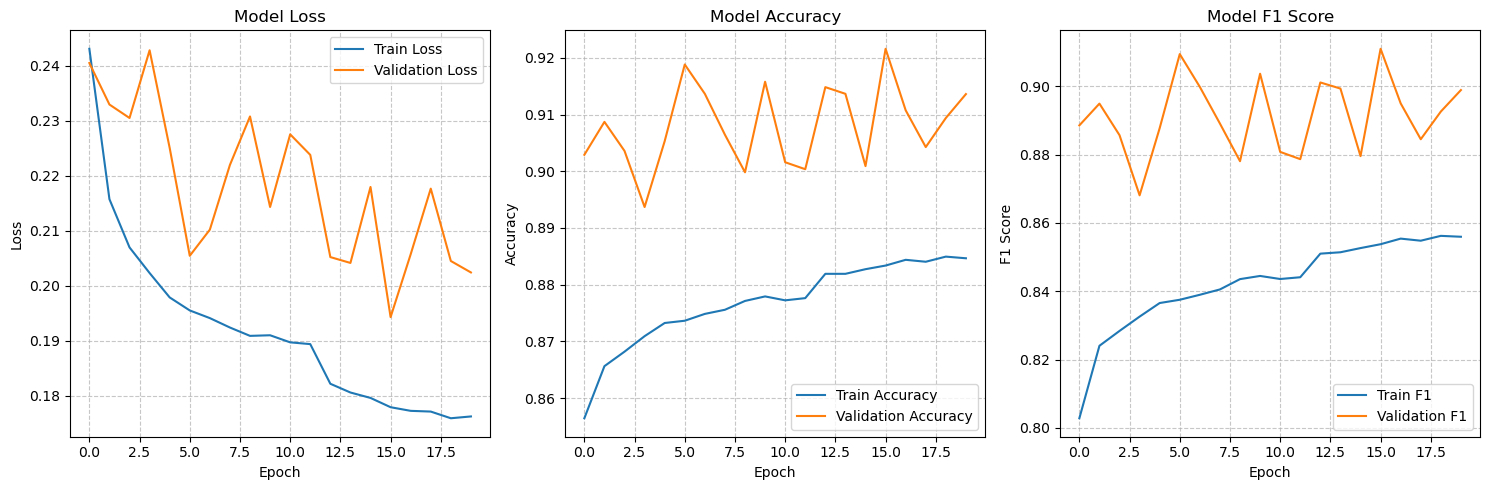


Evaluating student model on test set:


Testing:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.9127
Precision: 0.9185 (Normal: 0.9775, Abnormal: 0.9080)
Recall: 0.9127 (Normal: 0.4311, Abnormal: 0.9982)
F1 Score: 0.8978 (Normal: 0.5984, Abnormal: 0.9510)

Confusion Matrix:
[[ 1434  1892]
 [   33 18683]]


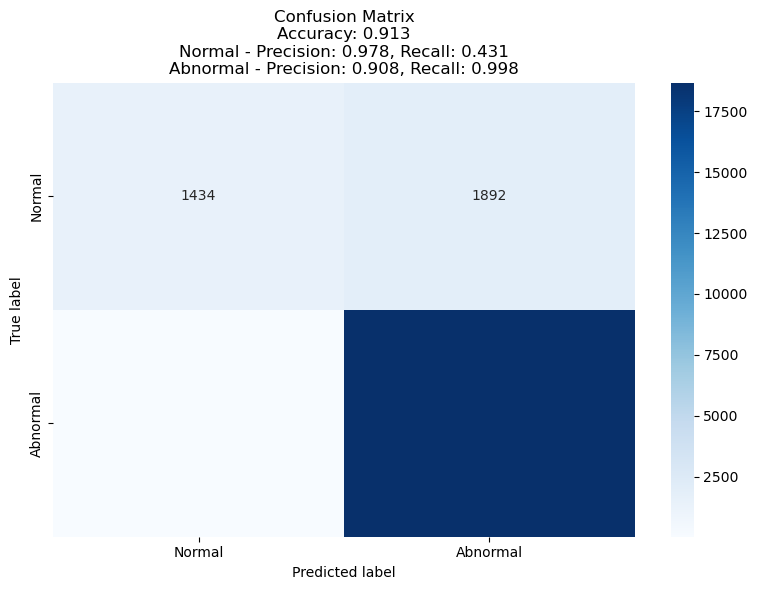


Evaluating teacher model on test set (resized to 120x120):


/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/689 [00:00<?, ?it/s]

Test Accuracy: 0.9236
Precision: 0.9221 (Normal: 0.9001, Abnormal: 0.9260)
Recall: 0.9236 (Normal: 0.5553, Abnormal: 0.9890)
F1 Score: 0.9158 (Normal: 0.6869, Abnormal: 0.9565)

Confusion Matrix:
[[ 1847  1479]
 [  205 18511]]
Student model saved as models/student_distilled_resnet_60x60.pth

Model Comparison:
Teacher model (resnet): 11,506,370 parameters (trainable: 11,506,370)
Student model (resnet): 11,502,690 parameters (trainable: 9,317,922)
Parameter reduction: 3,680 (0.0%)

Performance Comparison:
Teacher model - Test Accuracy: 0.9236, F1: 0.9158
Student model - Test Accuracy: 0.9127, F1: 0.8978

Inference Speed Comparison:


/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Teacher model average inference time: 2.65 ms
Student model average inference time: 5.58 ms
Speedup: 0.47x


In [21]:
 student_model, teacher_model, history, comparison = run_knowledge_distillation_from_scratch(
     data_dir='/gpfs/scratch/hz3106/Gashisdb/Gashisdb_processed/120x120',
     model_type='resnet',  # or 'custom'
     num_epochs=20,
     alpha=0.5,  # Distillation weight
     temperature=4.0  # Temperature for softening
 )